In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

For my model experiment, I am focusing on the Elkhorn Slough in Elkhorn, California, a coastal estuary known for its rich biodiversity and sensitivity to environmental changes. My experiment is designed to simulate the effects of reduced wind speeds on water temperature and dissolved oxygen levels over the next decade. Using historical meteorological and hydrological data, I will create a computational model that links wind-driven mixing to changes in surface water temperature and oxygen solubility. The model will include seasonal variations and tidal influences to accurately capture natural fluctuations in the estuary. I anticipate that reduced wind speeds will lead to decreased surface mixing, resulting in higher water temperatures during warm months. Consequently, I expect dissolved oxygen levels to decline due to the combined effects of warmer water and reduced aeration. By projecting these trends over ten years, the model will help assess potential stressors on aquatic life and inform local conservation strategies. Ultimately, this experiment aims to clarify the relationship between wind patterns and estuarine health in the face of climate variability.

## For Rilee's Model (Elkhorn Slough)

#### Question: If average wind speeds are reduced by 50%, how will water temperature and dissolved oxygen (DO) dynamics in Elkhorn Slough evolve over the next decade?

Coordinates: 

Longitude = $121.739^{\circ}$ W - $121.795^{\circ}$ W 

Latitude = $36.80^{\circ}$ N - $36.861^{\circ}$ N 

Grid: 240 rows by 360 columns


In the data file for my model, I will specifiy the following parameters in the `PARM04` namelist in the `data` file:

```
## 
usingSphericalPolarGrid=.TRUE.,
delX=360*0.00015556,
delY=240*0.00025417,
xgOrigin=-121.795,
ygOrigin=36.80,
```

The grid can be recreated in python as follows:

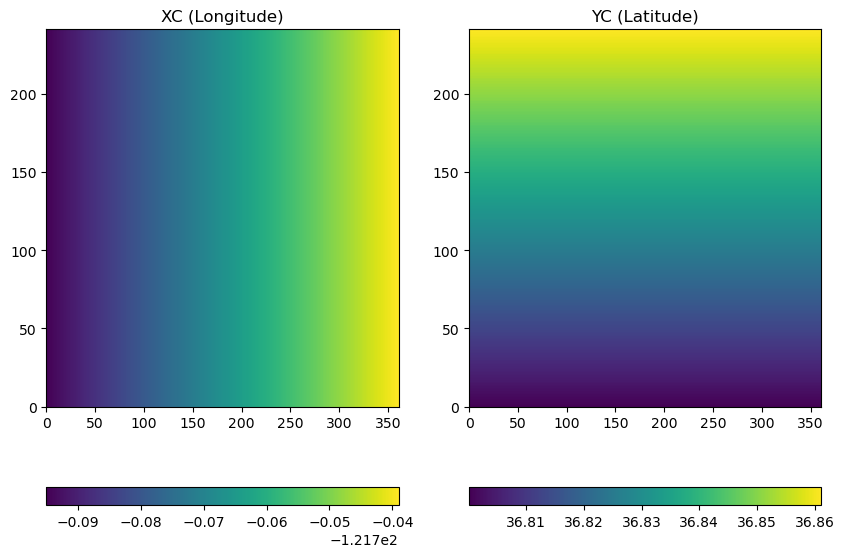

In [17]:
#Rilee grid
x_min, x_max = -121.795, -121.739
y_min, y_max = 36.80, 36.861
rn_rows = 240
rn_cols = 360

rdelX = 0.00015556
rdelY = 0.00025417

rxgOrigin = -121.795
rygOrigin = 36.8

# recreate the grids that will be used in the model
rxc = np.arange(rxgOrigin+rdelX/2, rxgOrigin+rn_cols*rdelX+rdelX/2, rdelX)
ryc = np.arange(rygOrigin+rdelY/2, rygOrigin+rn_rows*rdelY+rdelY/2, rdelY)
rXC, rYC = np.meshgrid(rxc, ryc)

#plot figure 
plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
rC = plt.pcolormesh(rXC, vmin=-121.795, vmax=-121.739)
plt.colorbar(rC, orientation = 'horizontal')
plt.title('XC (Longitude)')

plt.subplot(1,2,2)
rC = plt.pcolormesh(rYC)
plt.colorbar(rC, orientation = 'horizontal')
plt.title('YC (Latitude)')

plt.show()

### Visualizing the Grid on a Map with Cartopy
To get a sense of where the model is located on the globe, cartopy can be be used to plot the domain on the globe:

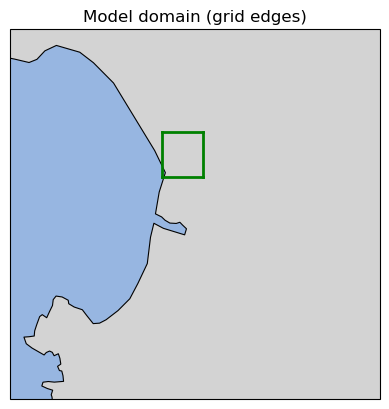

In [18]:
ax = plt.axes(projection=ccrs.PlateCarree())   # local map = PlateCarree
ax.set_extent([-122, -121.5, 36.5, 37], crs=ccrs.PlateCarree())

ax.coastlines(resolution="10m", linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor="lightgrey", zorder=0)
ax.add_feature(cfeature.OCEAN, zorder=0)

# your grid edges
ax.plot(rXC[:,0],  rYC[:,0],  'g-', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(rXC[:,-1], rYC[:,-1], 'g-', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(rXC[0,:],  rYC[0,:],  'g-', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(rXC[-1,:], rYC[-1,:], 'g-', linewidth=2, transform=ccrs.PlateCarree())

plt.title("Model domain (grid edges)")
plt.show()

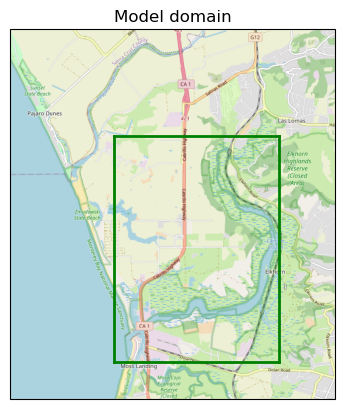

In [19]:
#Visualize Elkhorn Slough using pre-built map (so water can actually be seen)

tiler = cimgt.OSM()
ax = plt.axes(projection=tiler.crs)
ax.set_extent([-121.83, -121.72, 36.79, 36.89], crs=ccrs.PlateCarree())
ax.add_image(tiler, 13)  

# your grid edges
ax.plot(rXC[:,0],  rYC[:,0],  'g-', linewidth=2, transform=ccrs.PlateCarree(), zorder=2)
ax.plot(rXC[:,-1], rYC[:,-1], 'g-', linewidth=2, transform=ccrs.PlateCarree(), zorder=2)
ax.plot(rXC[0,:],  rYC[0,:],  'g-', linewidth=2, transform=ccrs.PlateCarree(), zorder=2)
ax.plot(rXC[-1,:], rYC[-1,:], 'g-', linewidth=2, transform=ccrs.PlateCarree(), zorder=2)

plt.title("Model domain")
plt.show()

### Visualizing the Grid Spacing
The model grid is defined in terms of units in longitude and latitude although it is useful to quantify the grid spacing in terms of more familiar units, such as meters. The following `great_circle_distance` function can be used to quantify this distance:

In [20]:
def great_circle_distance(lon_ref, lat_ref, Lon, Lat):
    earth_radius = 6371000
    lon_ref_radians = np.radians(lon_ref)
    lat_ref_radians = np.radians(lat_ref)
    lons_radians = np.radians(Lon)
    lats_radians = np.radians(Lat)
    lat_diff = lats_radians - lat_ref_radians
    lon_diff = lons_radians - lon_ref_radians
    d = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat_ref_radians) * np.cos(lats_radians) * np.sin(lon_diff * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return(h)

In [21]:
#loop through points to  generate inter-point distances in the horizontal (dXC) and vertical (dYC) directions:
rdXC = np.zeros((np.shape(rXC)[0], np.shape(rXC)[1]-1))
for row in range(np.shape(rXC)[0]):
    for col in range(np.shape(rXC)[1]-1):
        rdXC[row,col] = great_circle_distance(rXC[row,col], rYC[row,col], rXC[row,col+1], rYC[row,col+1])

rdYC = np.zeros((np.shape(rYC)[0]-1, np.shape(rYC)[1]))
for row in range(np.shape(rXC)[0]-1):
    for col in range(np.shape(rXC)[1]):
        rdYC[row,col] = great_circle_distance(rXC[row,col], rYC[row,col], rXC[row+1,col], rYC[row+1,col])

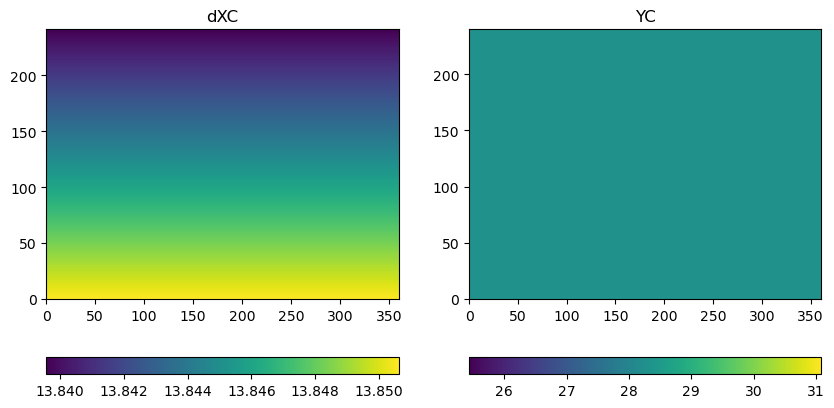

In [22]:
#make a plot to show resolution in METERS
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(rdXC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('dXC')

plt.subplot(1,2,2)
C = plt.pcolormesh(rdYC.round(3))
plt.colorbar(C, orientation = 'horizontal')
plt.title('YC')

plt.show()